# load data and checkpoint

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os,sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(sys.argv[1])))) # to import shared utils
import torch
import numpy as np
import pickle
import json
import h5py
import copy
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from utils.misc import todevice
from model.net import XNMNet
from model.composite_modules import MODULE_INPUT_NUM
module_names = list(MODULE_INPUT_NUM.keys())
print(module_names)


question_pt = '/data/sjx/exp/XNM/VQA/data/val_questions.pt'
feature_h5 = '/data/sjx/exp/XNM/VQA/data/trainval_feature.h5'
vocab_json = '/data/sjx/exp/XNM/VQA/data/trainval_vocab.json'
ckpt = '/data/sjx/exp/XNM/VQA/stack_trainval_sigmoid_T3/model.pt'
image_dir = '/data/sjx/dataset/mscoco/val2014'
ann_file = '/data/sjx/dataset/mscoco/annotations/instances_val2014.json'
coco = COCO(ann_file)

def invert_dict(d):
    return {v: k for k, v in d.items()}

def expand_batch(*args):
    return (t.unsqueeze(0) for t in args)

with open(vocab_json, 'r') as f:
    vocab = json.load(f)
    vocab['question_idx_to_token'] = invert_dict(vocab['question_token_to_idx'])
    vocab['answer_idx_to_token'] = invert_dict(vocab['answer_token_to_idx'])
    vocab['program_idx_to_token'] = invert_dict(vocab['program_token_to_idx'])

with open(question_pt, 'rb') as f:
    obj = pickle.load(f)
    questions = torch.LongTensor(np.asarray(obj['questions']))
    questions_len = torch.LongTensor(np.asarray(obj['questions_len']))
    q_image_indices = obj['image_idxs'] # coco_id
    answers = obj['answers']

with h5py.File(feature_h5, 'r') as f:
    coco_ids = f['ids'][()]
feat_coco_id_to_index = {id: i for i, id in enumerate(coco_ids)}


def getitem(index):
    q = questions[index]
    q_len = questions_len[index]
    a = answers[index]
    coco_id = q_image_indices[index]
    index = feat_coco_id_to_index[coco_id] # feature index
    with h5py.File(feature_h5, 'r') as f:
        vision_feat = f['features'][index]
        boxes = f['boxes'][index]
        w = f['widths'][index]
        h = f['heights'][index]
    vision_feat = torch.from_numpy(vision_feat).float()
    num_feat = boxes.shape[1]
    relation_mask = np.zeros((num_feat, num_feat))
    for i in range(num_feat):
        for j in range(i+1, num_feat):
            # if there is no overlap between two bounding box
            if boxes[0,i]>boxes[2,j] or boxes[0,j]>boxes[2,i] or boxes[1,i]>boxes[3,j] or boxes[1,j]>boxes[3,i]:
                pass
            else:
                relation_mask[i,j] = relation_mask[j,i] = 1
    relation_mask = torch.from_numpy(relation_mask).byte()
    q, q_len, vision_feat, relation_mask = expand_batch(q, q_len, vision_feat, relation_mask)
    return coco_id, boxes, w, h, a, q, q_len, vision_feat, relation_mask


device = 'cuda'
loaded = torch.load(ckpt, map_location={'cuda:0': 'cpu'})
model_kwargs = loaded['model_kwargs']
model_kwargs.update({'vocab': vocab, 'device': device})
model = XNMNet(**model_kwargs).to(device)
model.load_state_dict(loaded['state_dict'])
model.eval()

['_NoOp', '_Find', '_Transform', '_Filter', '_And', '_Describe']
loading annotations into memory...
Done (t=6.21s)
creating index...
index created!


XNMNet(
  (classifier): Classifier(
    (drop): Dropout(p=0.5)
    (relu): ReLU()
    (fusion): Fusion()
    (lin11): Linear(in_features=4096, out_features=1024, bias=True)
    (lin12): Linear(in_features=1024, out_features=1024, bias=True)
    (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (map_vision_to_v): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=2048, out_features=512, bias=False)
  )
  (map_two_v_to_edge): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=1024, out_features=256, bias=False)
  )
  (token_embedding): Embedding(16140, 300)
  (dropout): Dropout(p=0.5)
  (_NoOp): NoOpModule()
  (_Find): FindModule(
    (map_c): Linear(in_features=1024, out_features=512, bias=True)
    (x_conv): Linear(in_features=512, out_features=2, bias=True)
    (drop): Dropout(p=0.5)
    (fusion): Fusion()
  )
  (_Transform): TransformModule(
    (ma

# run model

what is the man wearing on his head
predict: hat; answer: hat


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


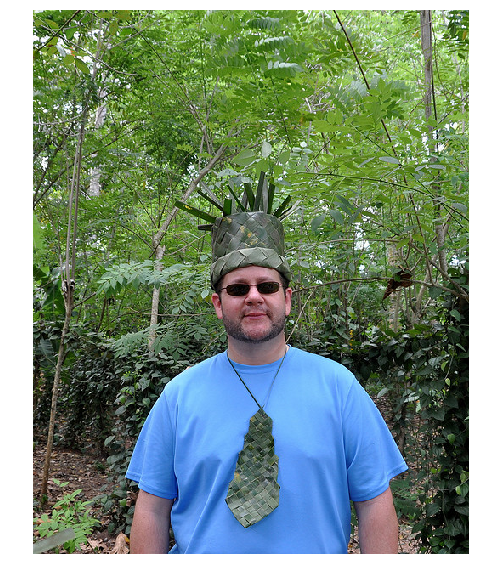

In [9]:
index = 54
coco_id, boxes, img_width, img_height, answer, *batch = getitem(index)
batch = [todevice(x, device) for x in batch]
img_obj = coco.loadImgs([coco_id])[0]
img = io.imread(os.path.join(image_dir, img_obj['file_name']))
# print(img.shape, img_height, img_width)
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
plt.axis('off')
plt.imshow(img)
q, q_len = batch[:2]
q_str = ' '.join([vocab['question_idx_to_token'][i.item()] for i in q[0, :q_len]])
print(q_str)

logits, others = model(*batch)
predict = torch.max(logits.squeeze(), dim=0)[1].item()
answer = np.argmax(np.bincount(answer))
print("predict: %s; answer: %s" % (vocab['answer_idx_to_token'][predict], vocab['answer_idx_to_token'][answer]))

# visualize

In [10]:
def drawrect(drawcontext, xy, outline=None, width=0):
    x1, y1, x2, y2 = xy
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)

def plot_attention(img, boxes, att):
    white = np.asarray([255, 255, 255])
    pixel_peak = np.zeros((img.shape[0], img.shape[1]))
    for k in range(36):
        for i in range(int(boxes[1][k]), int(boxes[3][k])):
            for j in range(int(boxes[0][k]), int(boxes[2][k])):
                pixel_peak[i,j] = max(pixel_peak[i,j], att[k])
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            img[i,j] = white * (1-pixel_peak[i,j]) + img[i,j] * pixel_peak[i,j]
    red_box = boxes[:, np.argmax(att)]
    img = Image.fromarray(np.uint8(img))
    draw = ImageDraw.Draw(img)
    drawrect(draw, red_box, outline='red', width=4)
    img = np.asarray(img)
    return img


num_module = len(module_names)
pylab.rcParams['figure.figsize'] = (10.0, 20.0)

for t in range(model_kwargs['T_ctrl']):
    print(t)
    input_att = list(zip(q_str.split(), others['cv_list'][t][0, :q_len].tolist()))
    print(input_att)
    for m in range(num_module):
        print("%s: %.3f" % (module_names[m], others['module_prob'][t][m][0]))
        a = others['att'][t][m][0][:,0].tolist()
        plot_img = plot_attention(copy.copy(img), boxes, a)
        plt.axis('off')
        plt.imshow(plot_img)
        plt.pause(0.0001)

0


KeyError: 'cv_list'

In [ ]:
print(img.shape)